In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_parquet('df_reponse_daily_train.parquet')
df = df.reset_index()
df = df[df['time']>'2015-01-01']

In [35]:
df.columns

Index(['time', 'stock_id', 'liq_weight', 'mktcap_weight', 'equal_weight',
       '21d_next_raw', '10d_next_raw', '5d_next_raw', '1d_next_raw',
       '21d_next_mktAdj', '10d_next_mktAdj', '5d_next_mktAdj',
       '1d_next_mktAdj', '21d_next_styAdj', '10d_next_styAdj',
       '5d_next_styAdj', '1d_next_styAdj', 'SIZE', 'SIZENL', 'LIQUIDITY',
       'BETA', 'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE', 'EARNYLD', 'GROWTH',
       'LTREV', 'STREV', 'industry_code', 'st_status', 'price'],
      dtype='object')

In [38]:
#seleting the price column
df_s = df[['time','stock_id','price']]
df_series = df_s.pivot(index='time', columns='stock_id')

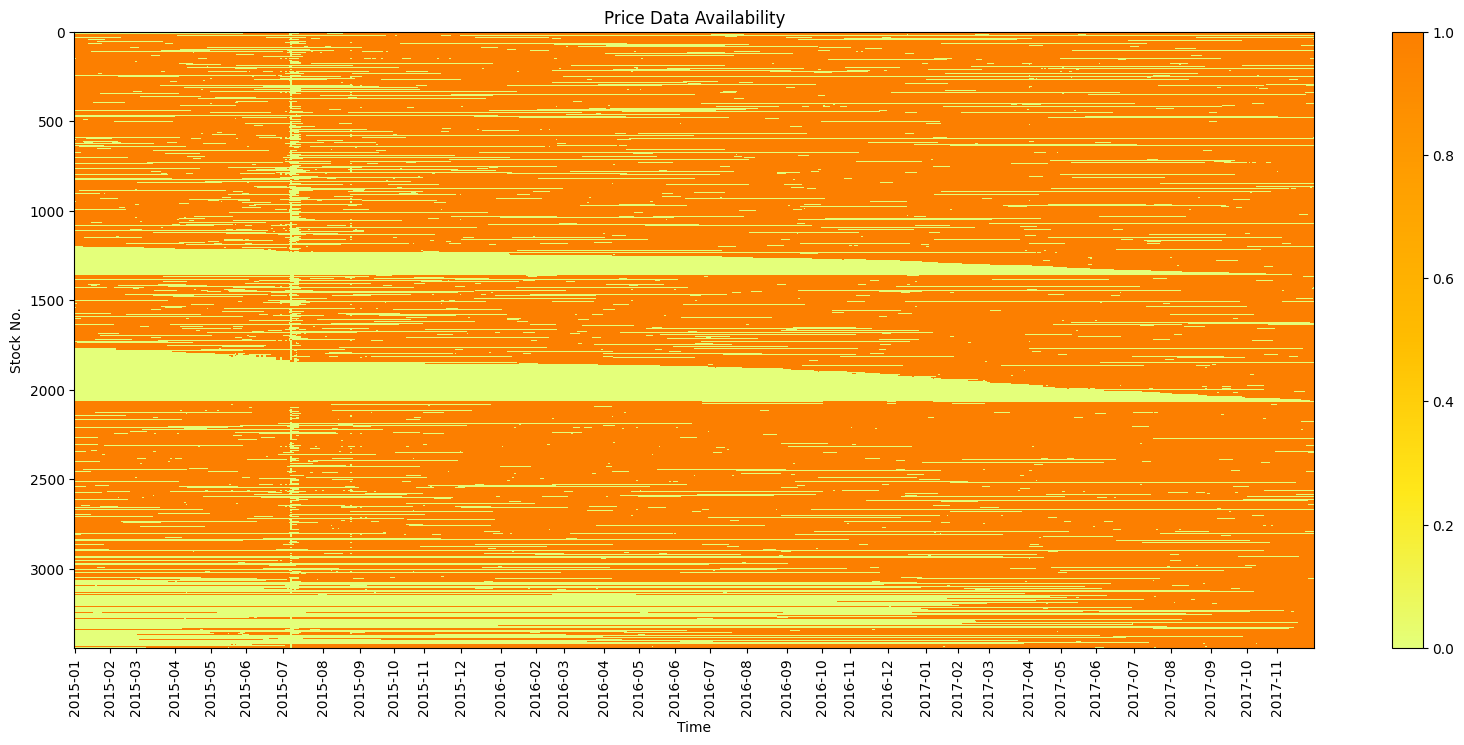

In [41]:
# Description of Nan Values among all data

data_presence = df_series.notna().astype(int)

# 绘制热图来表示数据的存在
plt.figure(figsize=(20, 8))
plt.imshow(data_presence.T, aspect='auto', cmap='Wistia', interpolation='nearest')

# 准备x轴标签
# 获取每个月的第一天
first_of_month = data_presence.index.to_series().resample('MS').min()
# 计算日期在data_presence.index中的位置
first_of_month_positions = [data_presence.index.get_loc(date) for date in first_of_month]
# 准备标签
labels = [date.strftime('%Y-%m') for date in first_of_month]
plt.xticks(ticks=first_of_month_positions, labels=labels, rotation=90)

# 添加color bar
plt.colorbar()

# 添加标题和轴标签
plt.title('Price Data Availability')
plt.xlabel('Time')
plt.ylabel('Stock No.')

plt.show()

In [40]:
#statistic for non-null rows
stockids = ['stock_'+ str(id) for id in df_series.reset_index()['price'].columns]
df_clean = df_series.droplevel('stock_id', axis=1)
df_clean.columns = stockids

df_clean.count().describe()

count    3444.000000
mean      541.142857
std       198.771872
min         1.000000
25%       487.000000
50%       618.000000
75%       692.000000
max       711.000000
dtype: float64

In [43]:
#select only stocks that have no more than n consecutive days of missing data
def filter_consecutive_missing(df,threshold):
    df_nan_count = df.isnull().rolling(window=threshold, min_periods=1).sum()
    df_filtered = df.loc[:, (df_nan_count < threshold).all()]
    
    return df_filtered

#select only stocks that have more than n days data
def filter_total_missing(df,threshold):
    df_filtered = df.loc[:, df.count() > threshold]
    
    return df_filtered

def gen_random_columns(df):
    rand_indices = np.random.choice(len(df.columns), size=4, replace=False)
    rand_cols = df.columns[rand_indices]

    return rand_cols

#generate the plots random time series
def plot_random_time_series(df, rand_cols):
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))

    for i, column_name in enumerate(rand_cols):
        row = i // 2
        col = i % 2
        rand_series = df[column_name].fillna(0.000001)
        axs[row, col].scatter(rand_series.index, rand_series, marker='o', s=10, linestyle='-', label='stock price')
        axs[row, col].scatter(rand_series[rand_series == 0.000001].index, rand_series[rand_series == 0.000001], marker='x', s=10, color='red', label='Missing')  # Highlight values equal to 0.000001 with red
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Price')
        axs[row, col].set_title(f'Random Time Series - {column_name}')
        axs[row, col].legend()
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

def fill_na_knn(df,k):
    imputer = KNNImputer(n_neighbors=k)
    
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [44]:
df_filtered = df_clean
#df_filtered = filter_consecutive_missing(df_clean,30)
df_filtered = filter_total_missing(df_filtered,710/2)
#df_filled = fill_na_knn(df_filtered,2)
len(df_filtered.columns)

2812

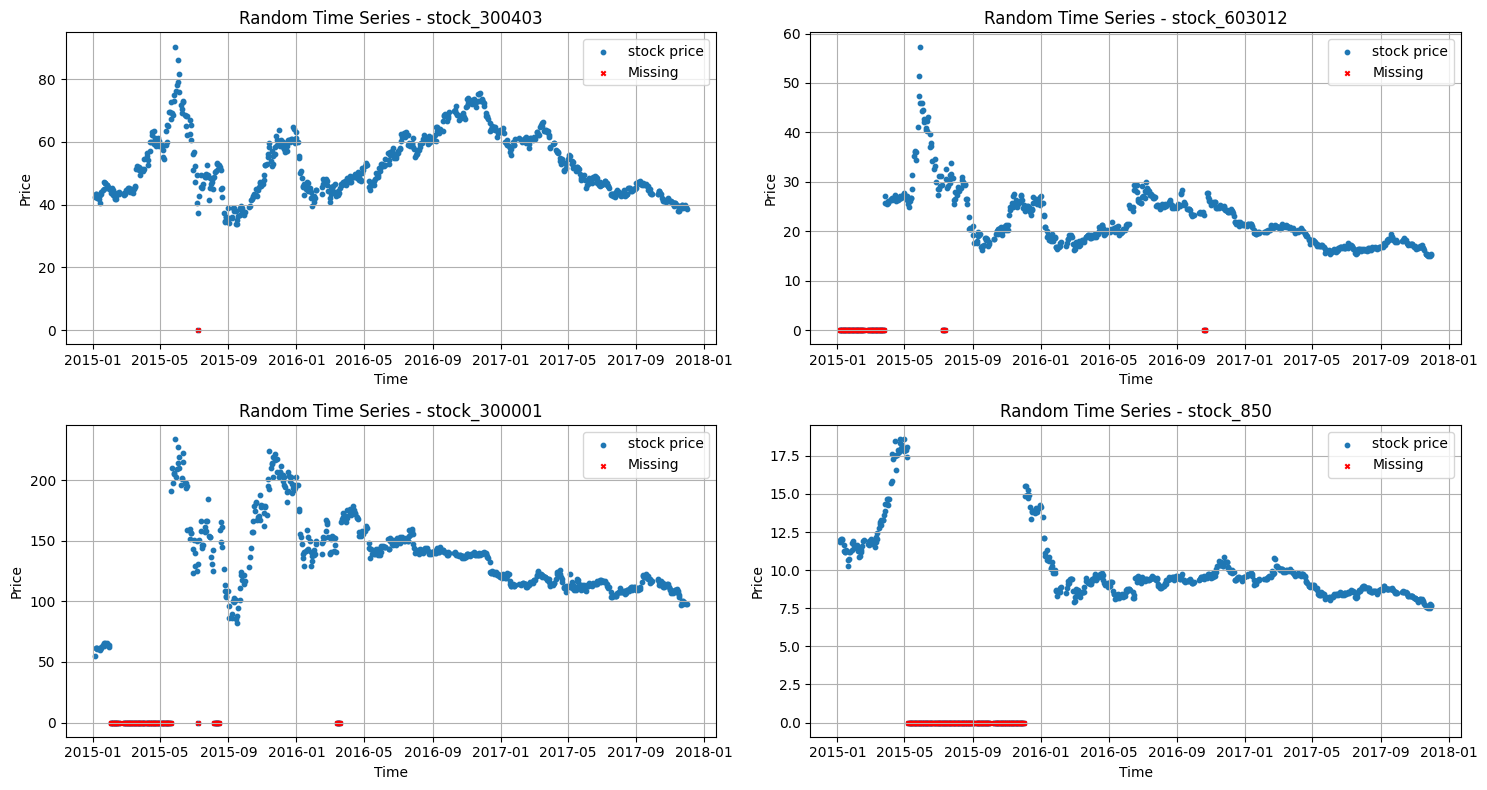

In [45]:
cols = gen_random_columns(df_filtered)
plot_random_time_series(df_filtered,cols)
#plot_random_time_series(df_filled,cols)

In [ ]:
df_series = df[['time', 'stock_id', 'liq_weight', 'mktcap_weight', 'equal_weight','21d_next_raw',
                'SIZE', 'SIZENL', 'LIQUIDITY','BETA', 'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE',
                'EARNYLD', 'GROWTH','LTREV', 'STREV', 'industry_code', 'st_status', 'price']].pivot(index='time', columns='stock_id')
df_series.columns = df_series.columns.get_level_values(0) + '_' + df_series.columns.get_level_values(1).astype(str)